## Attractor Identification Benchmarks for Random Boolean Networks
This notebook parses and plots the attractor identification benchmarks in the file `timing_results_RBN.xlsx`. This requires notebook requires the latest versions of `pandas`, `numpy`, `matplotlib`, and `openpyxl`.

All necessary libraries are imported here, except `openpyxl`, which is imported later by `pandas.read_excel()`.

In [6]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

### Data preparation
We begin by prepare the labels and colors for the plot.

In [14]:
methods=['stable_motifs_new','sm_jgtz', 'boolsim','CABEAN', 'PyBoolNet']
colors=['#5959AB','#F0810F','#cc0000','#ff33cc','#26B96F'] 
labels=['PyStableMotifs', 'Stable Motifs 2013','BoolSim', 'CABEAN', 'PyBoolNet']
color_dict=dict(zip(methods,colors))
label_dict=dict(zip(methods,labels))

Next, we import and organize raw timing data, and display completion counts.<br>
(To reproduce the results published in the application note, use the input file: _timing_results_RBN_paper.xlsx_ )

In [20]:
input_file_name='timing_results_RBN.xlsx'
df=pd.read_excel(input_file_name,engine='openpyxl')
df['N']=df.apply(lambda row: int(row['model'].split('N_')[-1].split('_')[0]),axis=1)
df=df[methods+['N']]
df.groupby('N').agg('count')[methods]

,stable_motifs_new,sm_jgtz,boolsim,CABEAN,PyBoolNet
N,,,,,
10,10,10,10,10,10
20,10,9,10,9,10
30,9,10,10,10,10
40,10,8,9,9,8
50,10,10,6,6,1


We process the data into a data dictionary, `N_data`, for plotting.

In [21]:
N_range=sorted(set(df['N']))
N_data={}
for N in N_range:
    N_data[N]=[]
    for method in methods:
        N_data[N].append(df[method][df[method].astype(str).str.replace('.', '').str.isnumeric()][df['N']==N].values)

We wish to plot the data on a log_60 scale, so we transform `N_data` accordingly to obtain `logN_data`.

In [22]:
def log60(x): return np.log(x)/np.log(60)
logN_data={}
for N in N_range:
    logN_data[N]=[np.log10(x.astype(float))/np.log10(60) for x in N_data[N]]

### Box plots with log base 60

We define the necessary plotting functions and parameters first.

In [23]:
N_methods=len(methods)
N_network_sizes=len(N_range)
N_networks_per_size=10

fsa=16 # font size for incomplete count annotations and legend
fs=22 # font size for other plot elements

# important vertical axis values
ymax = log60(12*3600)+0.25
cutoff_time_seconds=12*3600
log_cutoff_time=log60(cutoff_time_seconds)

# horizontal axis values
xmax=(N_methods+2)*N_network_sizes
xlims = [0,xmax]
xticks=np.linspace(N_methods+2,xmax, N_network_sizes)-((N_methods+2)/2.)

# box plot horizontal positions
positions={}
pos_index=1
for N in N_range:
    positions[N]=range(pos_index,N_methods+pos_index)
    pos_index+=N_methods+2

# tick variables
ytick_pos = [-1,0,1,2]
minor_interval=5 # for vertical axis
mticks=[] # minor ticks for the vertical axis
for k in ytick_pos:
    mticks+=[log60(60**k+i*60**k) for i in range(minor_interval,60,minor_interval)]

# prepare box plot properties
medianprops = dict(linestyle='-', linewidth=1.5, color='#011A27')
boxprops = dict(linestyle='-', linewidth=0.5, color='black')    
    
# box plot parameters
boxwidths=0.9

# labels
xlab=r'$N$'
ylab=r'Log completion time ($log_{60} T/sec )$'
yticklab=[r'$\frac{1}{60}$ sec.','1 sec.','1 min.','1 hr.']
timeoutlab='Timeout Threshold (12 hours)'

Lastly, we construct and display the figure.

/home/david/anaconda2/envs/python_3_env/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/david/anaconda2/envs/python_3_env/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/david/anaconda2/envs/python_3_env/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (whi

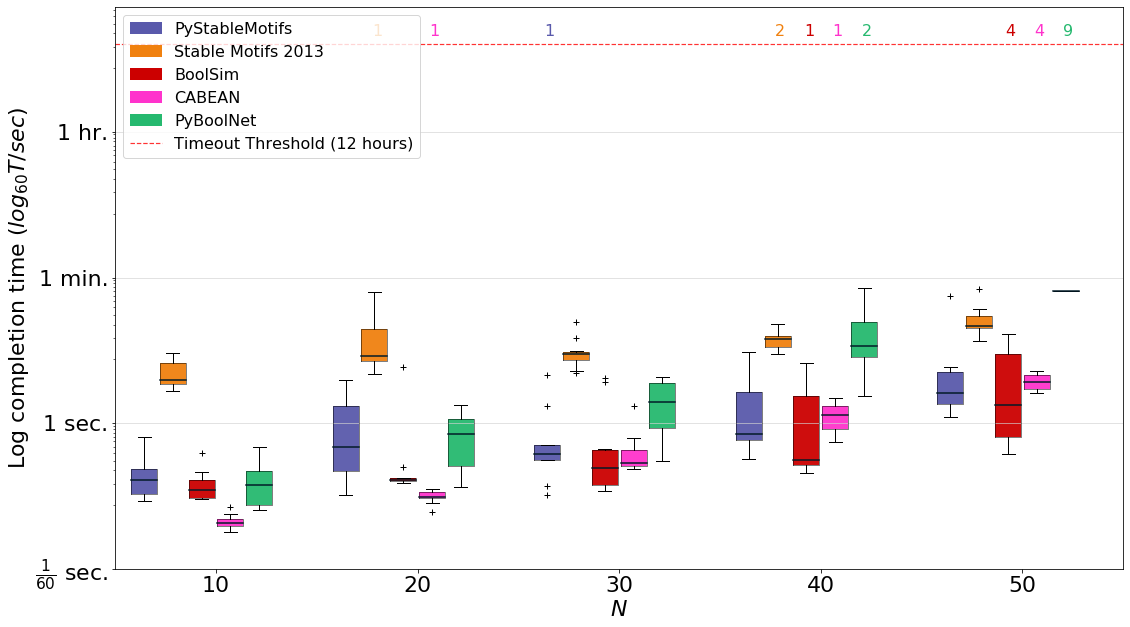

In [24]:
# initialize plots
fig, ax1 = plt.subplots(figsize=(16, 12),facecolor='white')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.8)

# construct box plots (using the log-transformed data)
for N in N_range:
    bp = ax1.boxplot(logN_data[N], notch=0, sym='+', vert=1, whis=1.5,positions=positions[N],
                     widths=boxwidths,medianprops=medianprops, boxprops=boxprops)
    
    for i in range(N_methods):
        box = bp['boxes'][i]
        box_x = []
        box_y = []
        for j in range(N_methods):
            box_x.append(box.get_xdata()[j])
            box_y.append(box.get_ydata()[j])
        box_coords = np.column_stack([box_x, box_y])
        ax1.add_patch(Polygon(box_coords, facecolor=color_dict[methods[i]],alpha=0.95))
        #adding the completion counts
        not_completed=N_networks_per_size-len(N_data[N][i])
        if not_completed!=0:
            ax1.annotate(not_completed,xy=(np.mean(box_x),ymax-0.2), color=color_dict[methods[i]],size=fsa)

# display plots
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='black', marker='+')

# horizontal line to show the timeout cutoff
hline3=plt.hlines(log_cutoff_time,0, xmax, colors='red', linestyles='--', 
                  label=timeoutlab, alpha=0.8, linewidth=1.2)

# prepare legend, ticks, and axis labels
legend_elements = [Patch(facecolor=color_dict[i], label=label_dict[i]) for i in methods]
legend_elements+=[hline3]

# set up axis ticks
ax1.set_yticks(ytick_pos)
ax1.set_yticklabels(yticklab,rotation=0)
minors=ax1.set_yticks(mticks,minor=True)

# display legend and labels
plt.legend(handles=legend_elements,fontsize=fsa, loc='upper left')
plt.xlim(xlims)
plt.ylim(ymax=ymax)
plt.xticks(xticks, N_range, fontsize=fs)
plt.yticks(fontsize=fs)
xlab=plt.xlabel(xlab,fontsize=fs)
ylab=plt.ylabel(ylab,fontsize=fs)